# TF-IDF

- Calcule la matriz TF-IDF para el corpus y muestre las palabras mas relevantes
- Aplique LDA - TF-IDF para identificar 7 topicos principales en las noticias 
- Muestre los resultados del modelo con 3 noticias ejemplo

In [1]:
# CELDA 1: Cargar datos
import pandas as pd
import numpy as np

df = pd.read_csv(
    "noticias_unificadas.tsv",
    encoding="utf-8",
    sep="\t",
    dtype={"fecha": "string", "titulo": "string", "contenido": "string", "seccion": "string", "link": "string"},
    quoting=0,
    na_filter=False
)


In [2]:

print(f"Total de documentos: {len(df)}")
df.head()

Total de documentos: 37746


,fecha,titulo,contenido,seccion,link
0,2025-11-09,jueces rechazan intento de afectacion a la ind...,desde la ciudad de tacna jueces y juezas de to...,Política,https://diariocorreo.pe/politica/jueces-rechaz...
1,2025-11-09,liga lo gritan los churres y todo el pueblo de...,alianza atletico le saco lustre a su clasifica...,Deportes,https://diariocorreo.pe/deportes/alianza-atlet...
2,2025-11-09,proponen sancionar con hasta anos de carcel a ...,la congresista elizabeth medina hermosillo de ...,Política,https://diariocorreo.pe/politica/proponen-sanc...
3,2025-11-09,este lunes inicia la semana de representacion ...,desde este lunes hasta el viernes de noviembre...,Política,https://diariocorreo.pe/politica/este-lunes-in...
4,2025-11-09,seleccion peruana evalua reprogramacion de par...,la federacion peruana de futbol fpf informo qu...,Deportes,https://diariocorreo.pe/deportes/seleccion-per...


In [3]:
topicos = df['seccion'].value_counts()
print(f"Total de categorías: {df['seccion'].nunique()}")
print("\nDistribución:")
print(topicos)

Total de categorías: 7

Distribución:
seccion
Política        12509
Espectáculos     6386
Mundo            5186
Deportes         4739
Cultura          3256
Economía         3168
Policiales       2502
Name: count, dtype: Int64


In [4]:
from utils.utils import clean_text

df["headline_text"] = (df["seccion"].fillna("") + " " + df["titulo"].fillna("") + " " + df["contenido"].fillna(""))
df["headline_text"] = df["headline_text"].map(clean_text)

print("Ejemplos de textos limpios:")
print(df["headline_text"].head(3))

Ejemplos de textos limpios:
0    politica jueces rechazan intento de afectacion...
1    deportes liga lo gritan los churres y todo el ...
2    politica proponen sancionar con hasta anos de ...
Name: headline_text, dtype: object


In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('default')
sns.set_palette("husl")

In [6]:
STOPWORDS = set(stopwords.words("spanish"))

STOP_EXTRA = {
    "dijo", "anos", "foto", "video", "puedes", "ver", "hoy", "ayer", "manana", 
    "mas", "recomendado", "ser", "dia", "dias", "tambien", "cada", "tras", 
    "soles", "uno", "dos", "tres", "asi", "mil", "ano", "año", "solo", 
    "senalo", "segun", "entre", "millones", "lugar", "puede", "haber", 
    "tener", "sol", "precio", "yape", "pai", "nueva", "hace", "hacer",
    "dijo", "ayer", "manana", "aqui", "alla", "sido", "sido"
}

STOPWORDS |= STOP_EXTRA

print(f"Total de stopwords: {len(STOPWORDS)}")
print(f"Ejemplos: {list(STOPWORDS)[:10]}")

Total de stopwords: 355
Ejemplos: ['estuvieseis', 'tendrán', 'ya', 'tuvieras', 'suyo', 'habían', 'había', 'estaban', 'has', 'teniendo']


In [7]:

spanish_stemmer = SnowballStemmer('spanish')

def preprocess_tfidf(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 3:
            stemmed = spanish_stemmer.stem(token)
            result.append(stemmed)
    return result

# Probar con un ejemplo
ejemplo = df["headline_text"].iloc[100]
print("Texto original:")
print(ejemplo[:200] + "...")
print("\nTokens procesados:")
print(preprocess_tfidf(ejemplo)[:20])

Texto original:
espectaculos diego de leon director de cine nosotros siempre quisimos contar la hazana militar entrevista diego de leon toma con calma el exito y hasta la polemica que ha generado en su primera semana...

Tokens procesados:
['espectacul', 'dieg', 'leon', 'director', 'cin', 'siempr', 'quis', 'cont', 'hazan', 'milit', 'entrev', 'dieg', 'leon', 'tom', 'calm', 'exit', 'polem', 'gener', 'primer', 'seman']


In [8]:
processed_docs = df['headline_text'].map(preprocess_tfidf)

In [9]:
print(processed_docs.iloc[0][:20])

['polit', 'juec', 'rechaz', 'intent', 'afect', 'independent', 'pod', 'judicial', 'ciud', 'tacn', 'juec', 'juez', 'pais', 'rechaz', 'tod', 'form', 'injerent', 'intent', 'afect', 'independent']


In [10]:
doc_lengths = processed_docs.apply(len)
print(f"\nEstadísticas de longitud de documentos:")
print(f"  Media: {doc_lengths.mean():.2f} tokens")
print(f"  Mediana: {doc_lengths.median():.2f} tokens")
print(f"  Min: {doc_lengths.min()}, Max: {doc_lengths.max()}")


Estadísticas de longitud de documentos:
  Media: 196.12 tokens
  Mediana: 166.00 tokens
  Min: 13, Max: 6532


In [11]:
dictionary = gensim.corpora.Dictionary(processed_docs)
for k, v in list(dictionary.items())[:10]:
    print(f"  {k}: {v}")

  0: abandon
  1: adem
  2: afect
  3: afectari
  4: agravi
  5: aprob
  6: aprueb
  7: ascens
  8: autonomi
  9: autoriz


In [12]:
dictionary.filter_extremes(
    no_below=5,
    no_above=0.5,
    keep_n=100000
)

In [13]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

print(f"Corpus creado: {len(bow_corpus)} documentos")

for word_id, freq in bow_corpus[100][:10]:
    print(f"  '{dictionary[word_id]}' → aparece {freq} veces")

Corpus creado: 37746 documentos
  'compromis' → aparece 1 veces
  'decision' → aparece 3 veces
  'embaj' → aparece 2 veces
  'lad' → aparece 1 veces
  'pais' → aparece 1 veces
  'part' → aparece 1 veces
  'polit' → aparece 2 veces
  'proyect' → aparece 1 veces
  'public' → aparece 4 veces
  'tod' → aparece 3 veces


In [14]:
tfidf_model = models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf_model[bow_corpus]

In [15]:
doc_id = 100
for word_id, freq in bow_corpus[doc_id][:10]:
    print(f"  '{dictionary[word_id]}': {freq} veces")

tfidf_doc = tfidf_corpus[doc_id]
sorted_tfidf = sorted(tfidf_doc, key=lambda x: x[1], reverse=True)

for word_id, score in sorted_tfidf[:10]:
    print(f"  '{dictionary[word_id]}': {score:.4f}")

print(f"\nTexto original:")
print(df.iloc[doc_id]['titulo'])
print(f"Categoría: {df.iloc[doc_id]['seccion']}")

  'compromis': 1 veces
  'decision': 3 veces
  'embaj': 2 veces
  'lad': 1 veces
  'pais': 1 veces
  'part': 1 veces
  'polit': 2 veces
  'proyect': 1 veces
  'public': 4 veces
  'tod': 3 veces
  'pelicul': 0.5536
  'hazan': 0.2838
  'cont': 0.1923
  'rescat': 0.1839
  'cint': 0.1620
  'chavin': 0.1460
  'milit': 0.1450
  'dieg': 0.1397
  'huant': 0.1390
  'leon': 0.1290

Texto original:
diego de leon director de cine nosotros siempre quisimos contar la hazana militar entrevista
Categoría: Espectáculos


In [16]:
from collections import defaultdict

def get_top_tfidf_words_by_category(df, tfidf_corpus, dictionary, top_n=20):

    category_tfidf = defaultdict(lambda: defaultdict(list))
    
    for idx, doc_tfidf in enumerate(tfidf_corpus):
        categoria = df.iloc[idx]['seccion']
        
        for word_id, tfidf_score in doc_tfidf:
            word = dictionary[word_id]
            category_tfidf[categoria][word].append(tfidf_score)
    
    category_top_words = {}
    
    for categoria, words_dict in category_tfidf.items():
        word_avg_scores = {
            word: np.mean(scores) 
            for word, scores in words_dict.items()
        }
        
        top_words = sorted(
            word_avg_scores.items(), 
            key=lambda x: x[1], 
            reverse=True
        )[:top_n]
        
        category_top_words[categoria] = top_words
    
    return category_top_words

In [17]:
category_keywords = get_top_tfidf_words_by_category(
    df, 
    tfidf_corpus, 
    dictionary, 
    top_n=15
)

In [18]:
print("PALABRAS MÁS RELEVANTES POR CATEGORÍA (TF-IDF)")
for categoria in ["Deportes", "Política", "Economía", "Mundo", "Espectáculos", "Cultura", "Policiales"]:
    if categoria in category_keywords:
        print(f"\n {categoria.upper()}")
        print("-" * 80)
        
        for i, (word, score) in enumerate(category_keywords[categoria], 1):
            print(f"  {i:2}. {word:20s} → TF-IDF: {score:.4f}")

PALABRAS MÁS RELEVANTES POR CATEGORÍA (TF-IDF)

 DEPORTES
--------------------------------------------------------------------------------
   1. jitsu                → TF-IDF: 0.7434
   2. silupu               → TF-IDF: 0.7431
   3. patent               → TF-IDF: 0.7309
   4. farah                → TF-IDF: 0.6756
   5. mussolini            → TF-IDF: 0.6133
   6. rubial               → TF-IDF: 0.6126
   7. lgtbi                → TF-IDF: 0.5832
   8. cojud                → TF-IDF: 0.5753
   9. uits                 → TF-IDF: 0.5299
  10. coli                 → TF-IDF: 0.5273
  11. lucer                → TF-IDF: 0.5194
  12. pug                  → TF-IDF: 0.5174
  13. operari              → TF-IDF: 0.5174
  14. strang               → TF-IDF: 0.5166
  15. molly                → TF-IDF: 0.5144

 POLÍTICA
--------------------------------------------------------------------------------
   1. hand                 → TF-IDF: 0.8029
   2. cepal                → TF-IDF: 0.7905
   3. libm           

In [19]:
def plot_top_tfidf_words(category_keywords, categories, num_words=10):

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Palabras más Relevantes por Categoría (TF-IDF)', 
                 fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, categoria in enumerate(categories):
        if idx >= len(axes):
            break
            
        if categoria in category_keywords:
            words_scores = category_keywords[categoria][:num_words]
            words = [w for w, _ in words_scores]
            scores = [s for _, s in words_scores]
            
            ax = axes[idx]
            bars = ax.barh(range(len(words)), scores, color='teal', alpha=0.7)
            ax.set_yticks(range(len(words)))
            ax.set_yticklabels(words, fontsize=9)
            ax.set_xlabel('TF-IDF Score', fontsize=10)
            ax.set_title(f'📂 {categoria}', fontsize=12, fontweight='bold')
            ax.invert_yaxis()
            ax.grid(axis='x', alpha=0.3)

            for i, (bar, score) in enumerate(zip(bars, scores)):
                ax.text(score + 0.001, i, f'{score:.3f}', 
                       va='center', fontsize=8)
        else:
            axes[idx].text(0.5, 0.5, f'Sin datos para\n{categoria}',
                          ha='center', va='center', 
                          transform=axes[idx].transAxes)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])
    
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_274463/1766553852.py:37: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/joelibaceta/examen-parcial-nlp/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128194 (\N{OPEN FILE FOLDER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


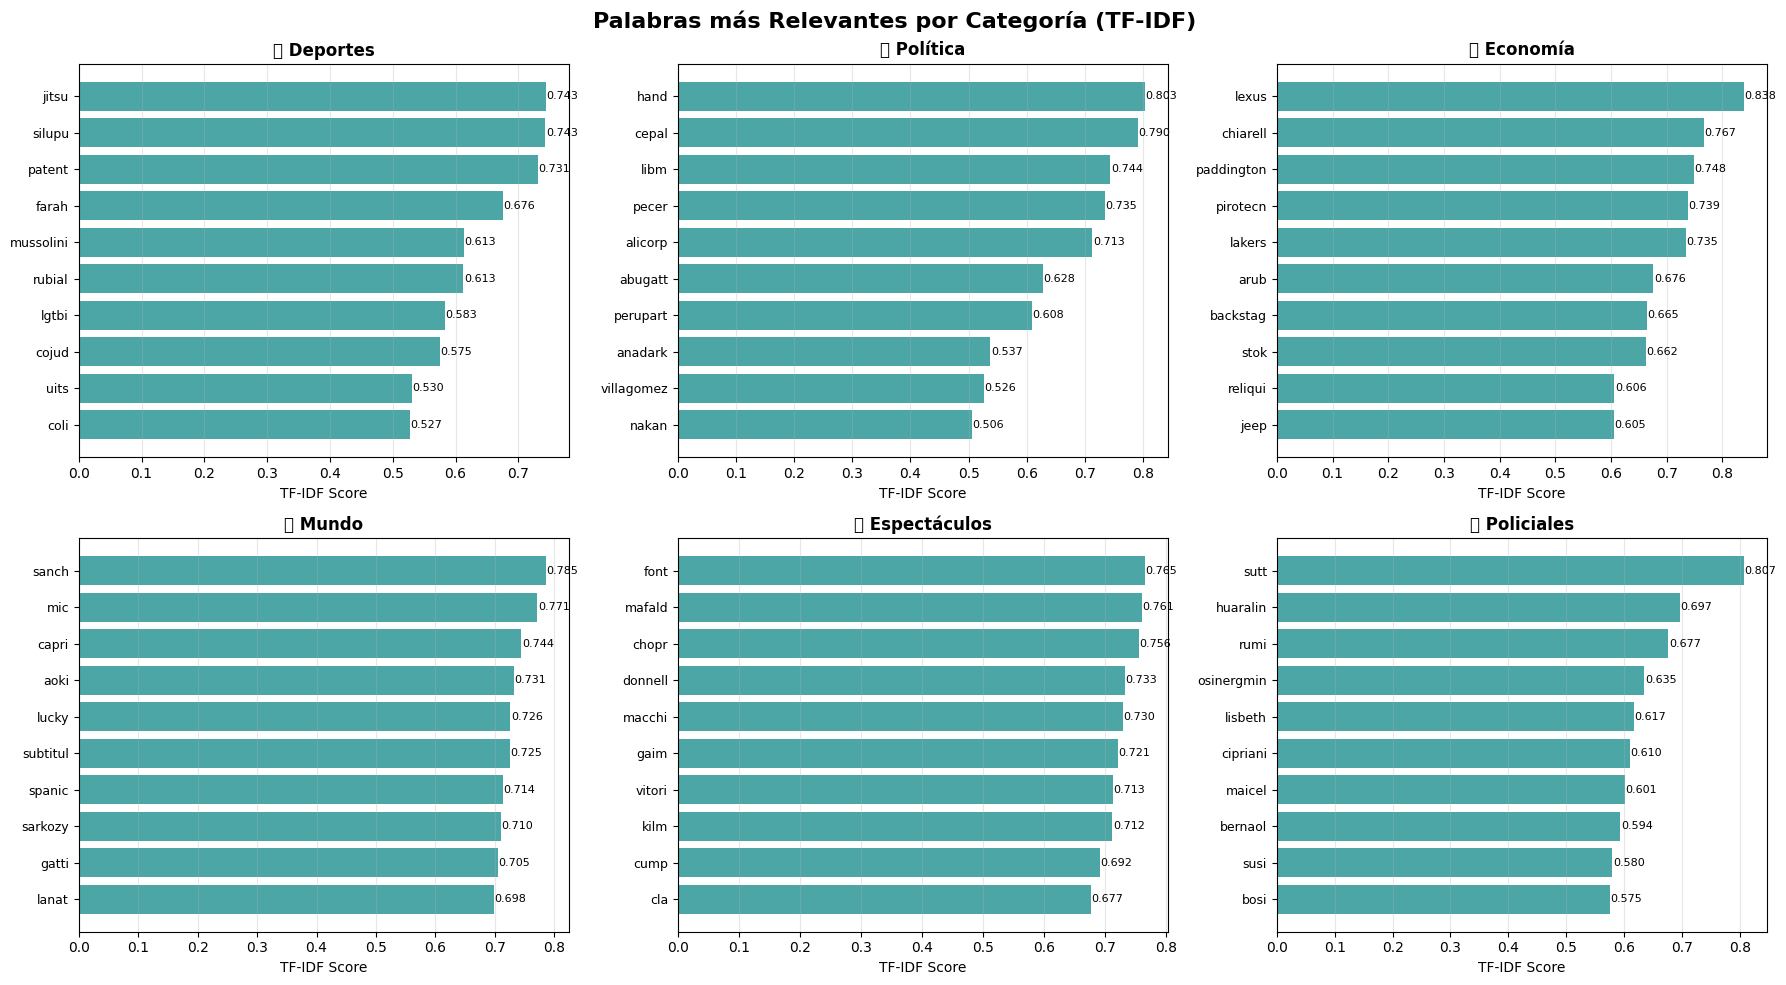

In [20]:
categorias_plot = ["Deportes", "Política", "Economía", "Mundo", "Espectáculos", "Policiales", "Cultura"]
plot_top_tfidf_words(category_keywords, categorias_plot, num_words=10)

In [21]:

from scipy import sparse
import numpy as np

num_docs_sample = min(1000, len(df)) 

print(f"Creando matriz TF-IDF para {num_docs_sample} documentos...")

corpus_sample = list(tfidf_corpus)[:num_docs_sample]
tfidf_matrix = gensim.matutils.corpus2dense(
    corpus_sample, 
    num_terms=len(dictionary)
).T

print(f"Matriz TF-IDF creada: {tfidf_matrix.shape}")
print(f"  Documentos: {tfidf_matrix.shape[0]}")
print(f"  Vocabulario: {tfidf_matrix.shape[1]}")
print(f"  Densidad: {(tfidf_matrix > 0).sum() / tfidf_matrix.size * 100:.2f}%")

Creando matriz TF-IDF para 1000 documentos...
Matriz TF-IDF creada: (1000, 25421)
  Documentos: 1000
  Vocabulario: 25421
  Densidad: 0.55%


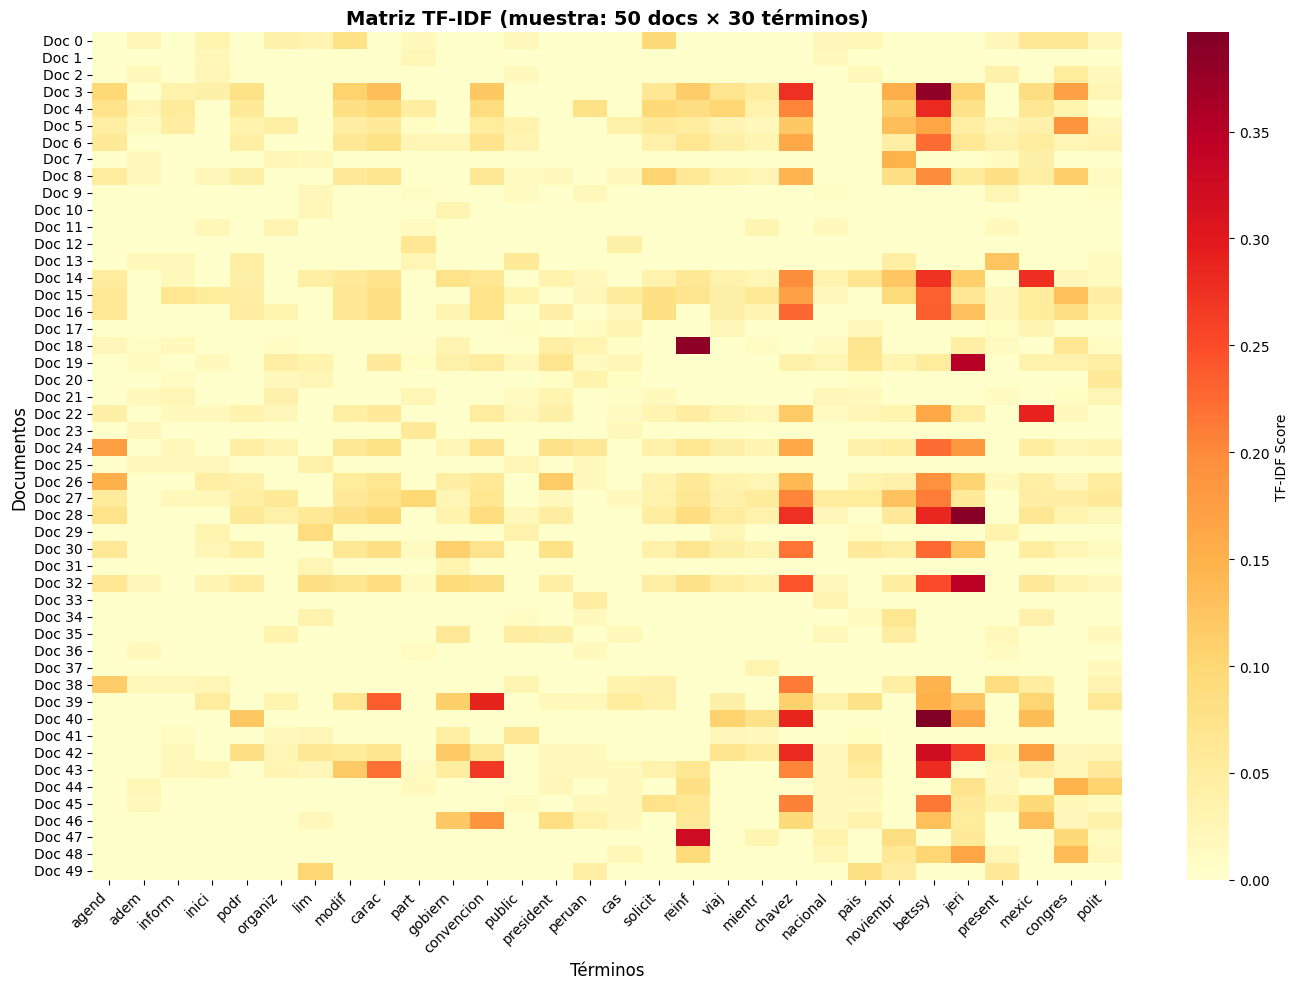

In [22]:
sample_size = 50
sample_terms = 30

term_frequencies = np.sum(tfidf_matrix[:sample_size] > 0, axis=0)
top_term_indices = np.argsort(term_frequencies)[-sample_terms:]

tfidf_viz = tfidf_matrix[:sample_size, top_term_indices]
term_names = [dictionary[i] for i in top_term_indices]

plt.figure(figsize=(14, 10))
sns.heatmap(
    tfidf_viz,
    cmap='YlOrRd',
    xticklabels=term_names,
    yticklabels=[f"Doc {i}" for i in range(sample_size)],
    cbar_kws={'label': 'TF-IDF Score'}
)
plt.title(f'Matriz TF-IDF (muestra: {sample_size} docs × {sample_terms} términos)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Términos', fontsize=12)
plt.ylabel('Documentos', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [1]:

print("ENTRENANDO LDA CON TF-IDF")

import multiprocessing

num_topics = 7
passes = 10
iterations = 200

lda_tfidf = gensim.models.LdaMulticore(
    corpus=list(tfidf_corpus), 
    id2word=dictionary,
    num_topics=num_topics,
    passes=passes,
    iterations=iterations,
    workers=min(4, multiprocessing.cpu_count() - 1),
    random_state=42,
    per_word_topics=True
)

print("\nModelo LDA-TF-IDF entrenado exitosamente")

ENTRENANDO LDA CON TF-IDF


NameError: name 'gensim' is not defined

In [ ]:

print("TÓPICOS DESCUBIERTOS POR LDA-TF-IDF")

for idx, topic in lda_tfidf.print_topics(-1, num_words=10):
    print(f'\nTópico {idx}:')
    print(f'   {topic}')

TÓPICOS DESCUBIERTOS POR LDA-TF-IDF

🔹 Tópico 0:
   0.002*"espectacul" + 0.002*"artist" + 0.002*"music" + 0.002*"hij" + 0.002*"pamel" + 0.002*"cuev" + 0.002*"vid" + 0.002*"conciert" + 0.002*"cantant" + 0.002*"cultur"

🔹 Tópico 1:
   0.007*"economi" + 0.005*"inversion" + 0.005*"empres" + 0.004*"petroperu" + 0.004*"crecimient" + 0.004*"merc" + 0.003*"econom" + 0.003*"sector" + 0.003*"product" + 0.003*"tas"

🔹 Tópico 2:
   0.008*"deport" + 0.005*"alianz" + 0.005*"club" + 0.005*"universitari" + 0.005*"futbol" + 0.004*"cop" + 0.004*"seleccion" + 0.004*"equip" + 0.004*"lig" + 0.004*"jug"

🔹 Tópico 3:
   0.003*"investig" + 0.003*"congres" + 0.003*"fiscal" + 0.003*"denunci" + 0.002*"boluart" + 0.002*"fiscali" + 0.002*"polici" + 0.002*"presunt" + 0.002*"policial" + 0.002*"cas"

🔹 Tópico 4:
   0.005*"sism" + 0.004*"terremot" + 0.004*"magnitud" + 0.004*"inund" + 0.003*"evacu" + 0.003*"urib" + 0.003*"hurac" + 0.003*"tsunami" + 0.003*"turbay" + 0.002*"incendi"

🔹 Tópico 5:
   0.014*"pap" + 0.008*"g

In [ ]:
import re

def extract_topic_words(lda_model, num_words=10):
    topics = {}
    for idx, topic in lda_model.print_topics(-1, num_words=num_words):
        words = re.findall(r'"([^"]+)"', topic)
        weights = re.findall(r'(\d+\.\d+)', topic)
        topics[idx] = list(zip(words, [float(w) for w in weights]))
    return topics

topic_words = extract_topic_words(lda_tfidf, num_words=12)

print("PALABRAS CLAVE POR TÓPICO (LDA-TF-IDF)")

for topic_id, words_weights in topic_words.items():
    print(f"\nTópico {topic_id}:")
    for word, weight in words_weights[:10]:
        print(f"   {word:20s} → {weight:.4f}")

PALABRAS CLAVE POR TÓPICO (LDA-TF-IDF)

📌 Tópico 0:
   espectacul           → 0.0020
   artist               → 0.0020
   music                → 0.0020
   hij                  → 0.0020
   pamel                → 0.0020
   cuev                 → 0.0020
   vid                  → 0.0020
   conciert             → 0.0020
   cantant              → 0.0020
   cultur               → 0.0020

📌 Tópico 1:
   economi              → 0.0070
   inversion            → 0.0050
   empres               → 0.0050
   petroperu            → 0.0040
   crecimient           → 0.0040
   merc                 → 0.0040
   econom               → 0.0030
   sector               → 0.0030
   product              → 0.0030
   tas                  → 0.0030

📌 Tópico 2:
   deport               → 0.0080
   alianz               → 0.0050
   club                 → 0.0050
   universitari         → 0.0050
   futbol               → 0.0050
   cop                  → 0.0040
   seleccion            → 0.0040
   equip                → 0.004

In [ ]:
topic_names = {
    0: "Espectáculos",
    1: "Economía",
    2: "Deportes",
    3: "Policiales",
    4: "Clima",
    5: "Mundo",
    6: "Política",
}


print("TÓPICOS CON NOMBRES INTERPRETATIVOS")

for topic_id, words_weights in topic_words.items():
    print(f"\n{topic_names[topic_id]}")
    words = [w for w, _ in words_weights[:8]]
    print(f"   Palabras: {', '.join(words)}")

TÓPICOS CON NOMBRES INTERPRETATIVOS

Espectáculos
   Palabras: espectacul, artist, music, hij, pamel, cuev, vid, conciert

Economía
   Palabras: economi, inversion, empres, petroperu, crecimient, merc, econom, sector

Deportes
   Palabras: deport, alianz, club, universitari, futbol, cop, seleccion, equip

Policiales
   Palabras: investig, congres, fiscal, denunci, boluart, fiscali, polici, presunt

Clima
   Palabras: sism, terremot, magnitud, inund, evacu, urib, hurac, tsunami

Mundo
   Palabras: pap, gaz, israeli, israel, francisc, vatican, leon, pontific

Política
   Palabras: president, trump, ministr, congres, boluart, gobiern, pais, polit


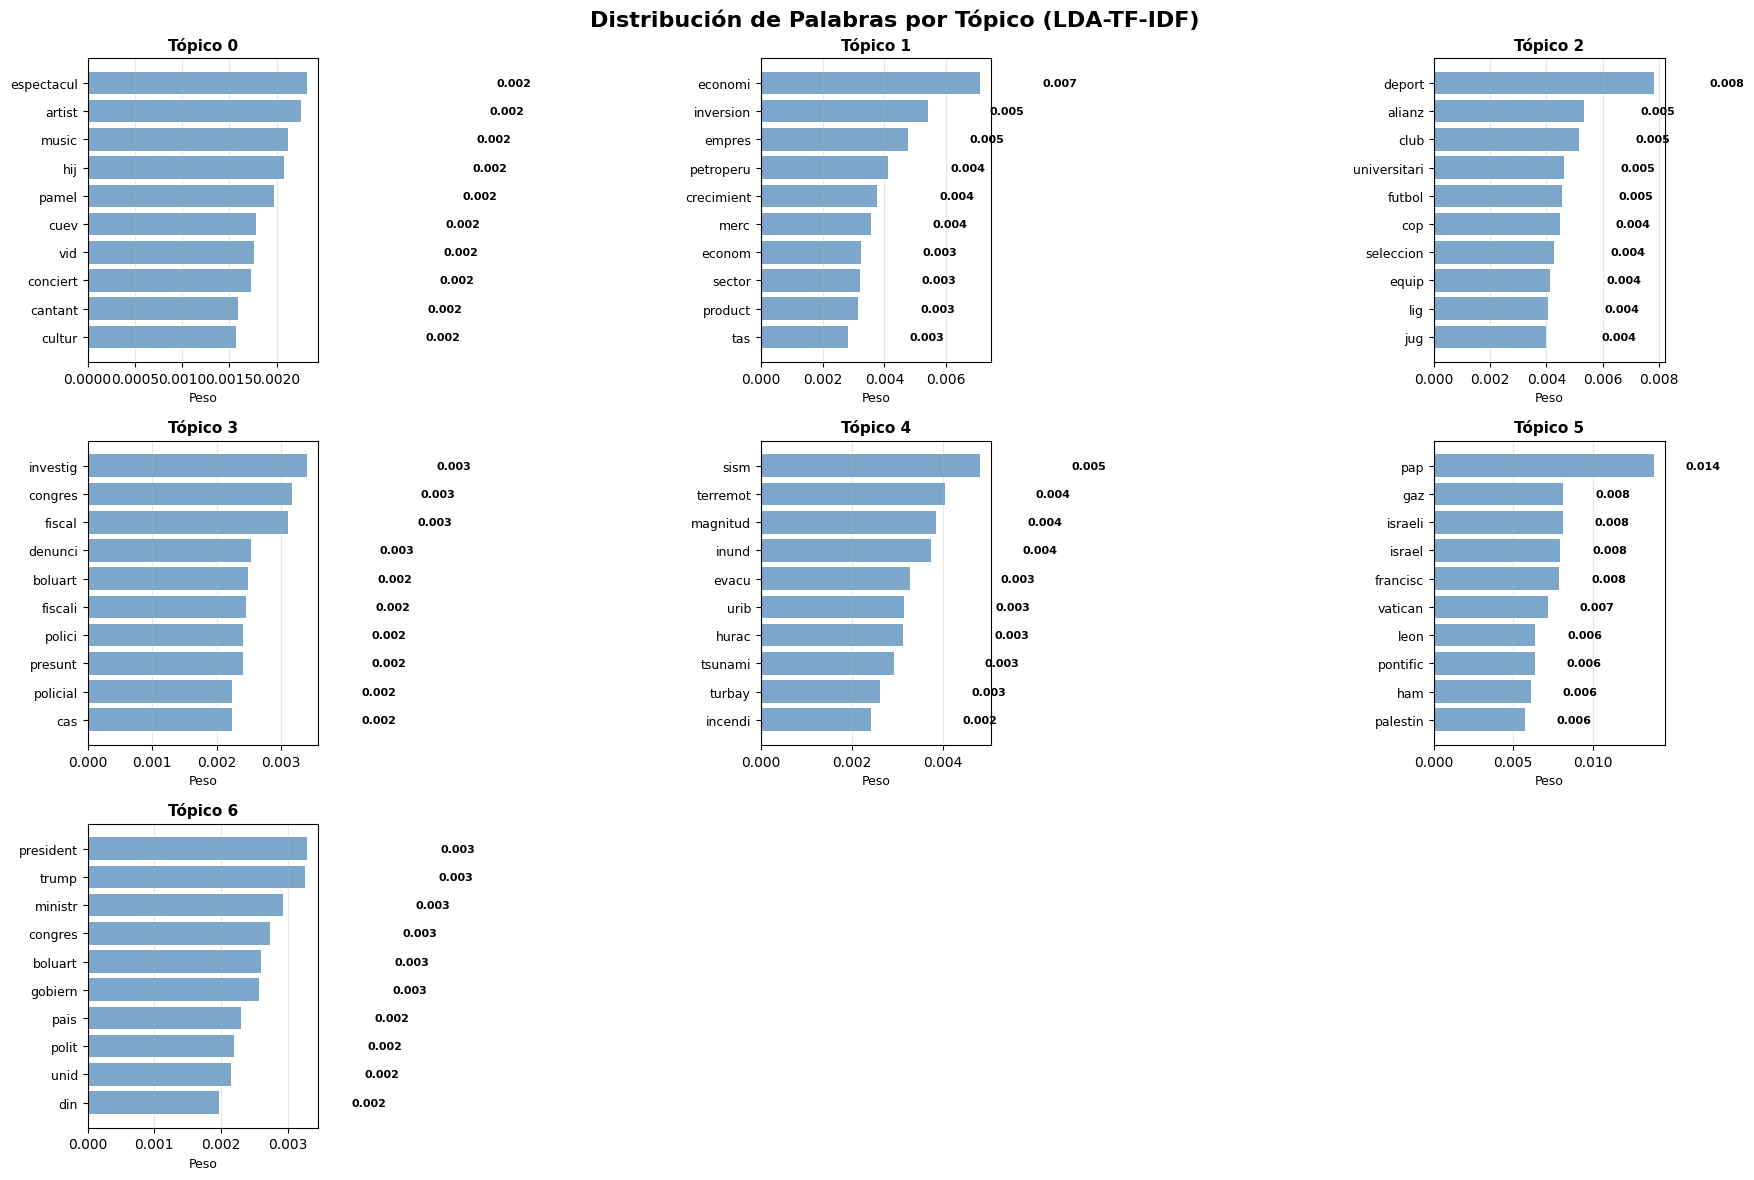

In [ ]:
def visualize_lda_topics(lda_model, topic_names=None, num_words=10):
    """Visualiza tópicos con gráficos de barras"""
    topics = lda_model.show_topics(num_topics=-1, num_words=num_words, formatted=False)
    
    num_topics = len(topics)
    cols = 3
    rows = (num_topics + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
    fig.suptitle('Distribución de Palabras por Tópico (LDA-TF-IDF)', 
                 fontsize=16, fontweight='bold')
    axes = axes.flatten() if num_topics > 1 else [axes]
    
    for idx, (topic_id, words) in enumerate(topics):
        if idx >= len(axes):
            break
        
        word_list = [word for word, _ in words]
        weight_list = [weight for _, weight in words]
        
        title = f"Tópico {topic_id}"
        if topic_names and topic_id in topic_names:
            title += f"\n{topic_names[topic_id]}"
        
        ax = axes[idx]
        bars = ax.barh(range(len(word_list)), weight_list, color='steelblue', alpha=0.7)
        ax.set_yticks(range(len(word_list)))
        ax.set_yticklabels(word_list, fontsize=9)
        ax.set_xlabel('Peso', fontsize=9)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        for i, weight in enumerate(weight_list):
            ax.text(weight + 0.002, i, f'{weight:.3f}', 
                   va='center', fontsize=8, fontweight='bold')
    
    # Ocultar ejes vacíos
    for idx in range(len(topics), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

visualize_lda_topics(lda_tfidf, topic_names=None, num_words=10)

In [ ]:
def classify_documents_lda(lda_model, corpus, df, threshold=0.3):
    results = []
    
    for idx, doc in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(doc)
        
        if topic_dist:
            topic_dist_sorted = sorted(topic_dist, key=lambda x: x[1], reverse=True)
            dominant_topic, prob = topic_dist_sorted[0]
            
            results.append({
                'doc_id': idx,
                'titulo': df.iloc[idx]['titulo'][:60] + '...' if len(df.iloc[idx]['titulo']) > 60 else df.iloc[idx]['titulo'],
                'categoria_real': df.iloc[idx]['seccion'],
                'topic_dominante': topic_names.get(dominant_topic, f"Tópico {dominant_topic}"),
                'probabilidad': prob,
                'es_claro': prob >= threshold
            })
    
    return pd.DataFrame(results)

Clasificando documentos...


In [ ]:
print("Clasificando documentos...")
classification_results = classify_documents_lda(
    lda_tfidf, 
    list(tfidf_corpus), 
    df,
    threshold=0.3
)

In [ ]:

print("EJEMPLOS DE CLASIFICACIÓN")

sample_results = classification_results.groupby('categoria_real').head(3)

for _, row in sample_results.iterrows():
    print(f"\n{row['titulo']}")
    print(f"   Categoría real: {row['categoria_real']}")
    print(f"   Tópico asignado: {row['topic_dominante']} (prob: {row['probabilidad']:.3f})")

EJEMPLOS DE CLASIFICACIÓN

Jueces rechazan intento de afectación a la independencia del...
   Categoría real: Política
   Tópico asignado: Policiales (prob: 0.637)

Liga 1: Lo gritan los “Churres” y todo el pueblo de Sullana
   Categoría real: Deportes
   Tópico asignado: Deportes (prob: 0.925)

Proponen sancionar con hasta 10 años de cárcel a quienes se ...
   Categoría real: Política
   Tópico asignado: Política (prob: 0.511)

Este lunes inicia la semana de representación del Congreso
   Categoría real: Política
   Tópico asignado: Política (prob: 0.901)

Selección peruana evalúa reprogramación de partidos amistoso...
   Categoría real: Deportes
   Tópico asignado: Política (prob: 0.645)

“Geek Festival Perú 2025” se traslada al Parque de la Exposi...
   Categoría real: Espectáculos
   Tópico asignado: Espectáculos (prob: 0.908)

Jorge Espinoza y la celebración de los dones
   Categoría real: Cultura
   Tópico asignado: Espectáculos (prob: 0.942)

Yiddá Eslava lloró por críticas tras

In [ ]:
def classify_documents_lda(lda_model, corpus, df, threshold=0.3):

    results = []
    
    for idx, doc in enumerate(corpus):
        topic_dist = lda_model.get_document_topics(doc)
        
        if topic_dist:
            topic_dist_sorted = sorted(topic_dist, key=lambda x: x[1], reverse=True)
            dominant_topic, prob = topic_dist_sorted[0]
            
            results.append({
                'doc_id': idx,
                'titulo': df.iloc[idx]['titulo'][:60] + '...' if len(df.iloc[idx]['titulo']) > 60 else df.iloc[idx]['titulo'],
                'categoria_real': df.iloc[idx]['seccion'],
                'topic_dominante': topic_names.get(dominant_topic, f"Tópico {dominant_topic}"),
                'probabilidad': prob,
                'es_claro': prob >= threshold
            })
    
    return pd.DataFrame(results)

print("Clasificando documentos...")
classification_results = classify_documents_lda(
    lda_tfidf, 
    list(tfidf_corpus), 
    df,
    threshold=0.3
)

Clasificando documentos...


In [ ]:
print(f"\n{len(classification_results)} documentos clasificados")
print(f"Documentos con tópico claro (prob >= 0.3): {classification_results['es_claro'].sum()}")
print(f"Probabilidad promedio: {classification_results['probabilidad'].mean():.3f}")


37746 documentos clasificados
Documentos con tópico claro (prob >= 0.3): 37741
Probabilidad promedio: 0.806


In [ ]:
classification_results.head(5)

,doc_id,titulo,categoria_real,topic_dominante,probabilidad,es_claro
0,0,Jueces rechazan intento de afectación a la ind...,Política,Policiales,0.636642,True
1,1,Liga 1: Lo gritan los “Churres” y todo el pueb...,Deportes,Deportes,0.925075,True
2,2,Proponen sancionar con hasta 10 años de cárcel...,Política,Política,0.511307,True
3,3,Este lunes inicia la semana de representación ...,Política,Política,0.900526,True
4,4,Selección peruana evalúa reprogramación de par...,Deportes,Política,0.645010,True


In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_true = classification_results['categoria_real']
y_pred = classification_results['topic_dominante']

unique_categories = sorted(y_true.unique())
unique_topics = sorted(y_pred.unique())

cm = confusion_matrix(y_true, y_pred, labels=unique_categories)

cm_df = pd.DataFrame(
    cm,
    index=unique_categories,
    columns=unique_topics
)

print("MATRIZ DE CONFUSIÓN: Categorías Reales vs Tópicos LDA-TF-IDF")
print(cm_df)

MATRIZ DE CONFUSIÓN: Categorías Reales vs Tópicos LDA-TF-IDF
              Clima  Deportes  Economía  Espectáculos  Mundo  Policiales  \
Cultura           0         0         7          3203      6           4   
Deportes          0      4168         4           291      4         179   
Economía          0         4      2028           128      1          83   
Espectáculos      0        16         1          6158      1         180   
Mundo             0        19        39           683    390         586   
Policiales        0         0         3            55      2        2272   
Política          0         0        89           119     19        7166   

              Política  
Cultura             36  
Deportes            93  
Economía           924  
Espectáculos        30  
Mundo             3387  
Policiales         170  
Política          5116  


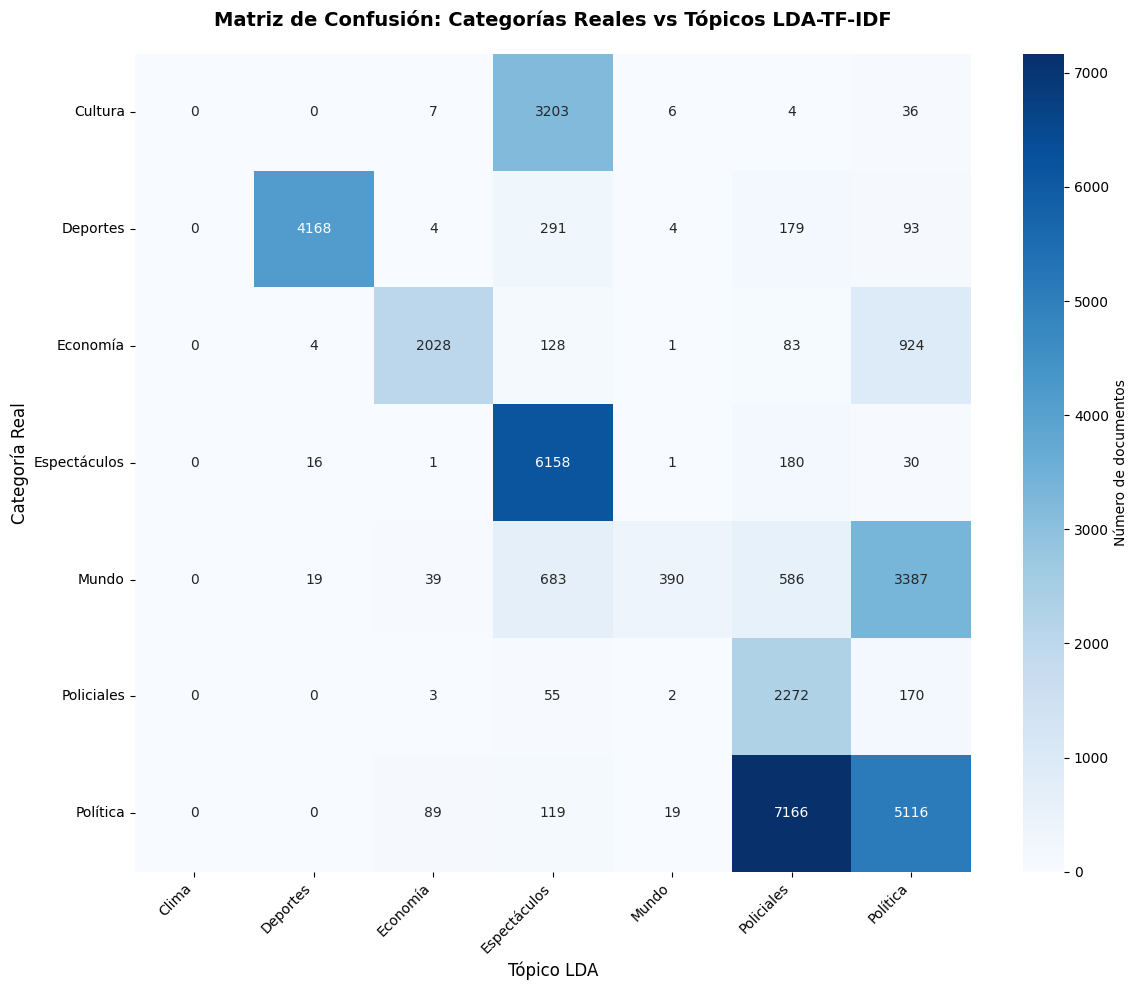

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar_kws={'label': 'Número de documentos'}
)
plt.title('Matriz de Confusión: Categorías Reales vs Tópicos LDA-TF-IDF', 
          fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Categoría Real', fontsize=12)
plt.xlabel('Tópico LDA', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from gensim.models import CoherenceModel


print("EVALUACIÓN DEL MODELO LDA-TF-IDF")

perplexity = lda_tfidf.log_perplexity(list(tfidf_corpus))
print(f"\nPerplejidad: {perplexity:.4f}")


coherence_model = CoherenceModel(
    model=lda_tfidf,
    texts=processed_docs,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()

EVALUACIÓN DEL MODELO LDA-TF-IDF

📊 Perplejidad: -9.3147
   (Más bajo = mejor)


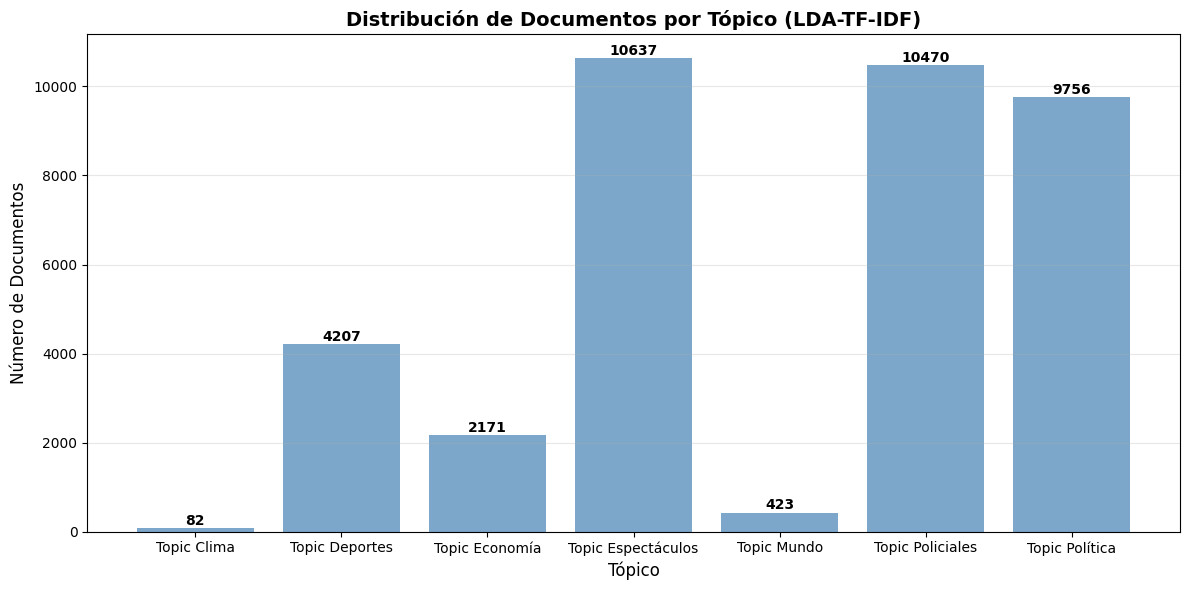


Documentos por tópico:
  Topic Clima: 82 documentos (0.2%)
  Topic Deportes: 4207 documentos (11.1%)
  Topic Economía: 2171 documentos (5.8%)
  Topic Espectáculos: 10637 documentos (28.2%)
  Topic Mundo: 423 documentos (1.1%)
  Topic Policiales: 10470 documentos (27.7%)
  Topic Política: 9756 documentos (25.8%)


In [ ]:
topic_distribution = classification_results['topic_dominante'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(topic_distribution)), topic_distribution.values, 
               color='steelblue', alpha=0.7)
plt.xlabel('Tópico', fontsize=12)
plt.ylabel('Número de Documentos', fontsize=12)
plt.title('Distribución de Documentos por Tópico (LDA-TF-IDF)', 
          fontsize=14, fontweight='bold')
plt.xticks(range(len(topic_distribution)), 
           [f"Topic {i}" for i in topic_distribution.index])
plt.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, topic_distribution.values)):
    plt.text(i, val + 10, str(val), ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nDocumentos por tópico:")
for topic_id, count in topic_distribution.items():
    print(f"  Topic {topic_id}: {count} documentos ({count/len(df)*100:.1f}%)")